In [284]:
# AAOAK9.py
# UC Davis BIM110B 
# Winter 2023
# Group 5: Anisha Kumar, Jasmine Rose Muolic, Blanca Osorio, Marc Ramirez, Emely Rivera 
# Automattic Assessment of Osteoarthritis in Canine Elbows
# Protype V1
import cv2
import pydicom as dicom
import numpy as np
# import matplotlib as mp
# plt = mp.pyplot
# imread, imshow, show, subplot, title, get_cmap, hist
import math
import skimage
# https://scikit-image.org/docs/stable/api/skimage.filters.html
# use code below to show the image
# plt.imshow(insertImagePixelArrayHere,cmap=plt.cm.gray)
from matplotlib.pyplot import imread, imshow, show, subplot, title, hist, cm

In [285]:
#import sys
#sys.executable # to check if python is running on the correct kernel, in case problems occur when running
# functions for computation ease later on
def intesityThresh(image,m,n,r2,r1=0): # image = pixels of the image
                                       # m = # of rows
                                       # n = # of columns
                                   # r2 = upper bound threshold
                                   # r1 = lower bound threshold, defaulted to 0 if no input
    thresh = image
    for i in range(0,m):
        for j in range (0,n):
            if image[i][j] >= r1 and image[i][j] <= r2:
                thresh[i][j] = 0
    return thresh
# Apply a filter N times
def applyNTimes(filt,image,n=1): # filt = filter used
                                 # image = pixels of the image
                                 # n = how many times to apply the filter
    index = 1
    medianImage = filt(image)
    while index < n:
        medianImage = filt(medianImage)
        index += 1
    return medianImage
def findPSNR(array1,array2,maxP = 2**12): # source: https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/
    mse = np.mean((array1-array2)**2)
    if mse == 0:
        return 100
    pSNR = 20 * math.log10(maxP/math.sqrt(mse))
    return pSNR

In [286]:
# R1
path = '/Users/marcramirez/Desktop/AAOAK9/Anonymous Rad Pt 2/R1/Elbow_Lf_Rf - 145421/Right_Fore_CR_CD_Extremity_10/IM-0003-0001.dcm'
# if fails add r to the beginning before the string ex. r'/Users/....
# R10 Elbow CR CD
# path = '/Users/marcramirez/Desktop/AAOAK9/Anonymous Rad Pt 2/R10/Elbow - Study_1/L_ELBOW_CR_CD_6/IM-0001-0001.dcm'

In [287]:
# path = input('Enter dicom path: ') # will prompt the user to input their file path and check if it is a dicom file
while True:
    if path[-4:] != '.dcm':
        path = input('The file you entered is not a DICOM file. Please re-enter a path leads to a Dicom file.')
    else:
        break
# This will be used to check if the input is a DICOM file

original image


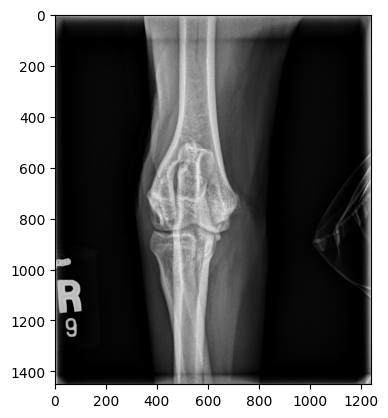

In [288]:
# open and read radiograph
rawImage = dicom.dcmread(path)
pixelsRaw = rawImage.pixel_array # 12-bit
print('original image')
imshow(pixelsRaw,cmap=cm.gray);

MaxComp= 4095


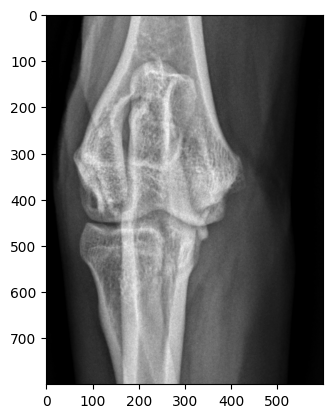

In [289]:
# will work on getting the software to detect the affected region and segment the image
# for now we will segment and work with the desired area of interest, the joint
# R1 Fore CR CD
onlyJoint = pixelsRaw[400:1200,300:900]
# R10 Elbow CR CD
# onlyJoint = pixelsRaw[800:,:1000]
m, n = np.shape(onlyJoint) # preset dimensions of the radiogrpah when opening them, will help to make code universal for
                                  # different sized radiograph inputs
tempMax = onlyJoint[0:m,0]
indexNum = 0
for i in onlyJoint:
    tempMax[indexNum] = max(i)
    indexNum +=1
compInt = max(tempMax) # intnesity to compoensate for filters, typically scale to values of -1 to 1
print('MaxComp=',compInt)
imshow(onlyJoint, cmap = cm.gray);

PSNR of Gaussian Deblurring = 31.400066065139377


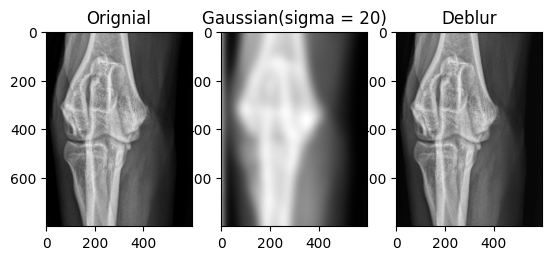

In [290]:
# Unsharp Masking (Deblurring)
gaussImage = compInt * skimage.filters.gaussian(onlyJoint,20) # standard deviation of 20
deblurImage = np.subtract(onlyJoint, gaussImage) # subtract the arrays
subplot(131); imshow(onlyJoint,cmap=cm.gray); title('Orignial')
subplot(132); imshow(gaussImage,cmap=cm.gray); title('Gaussian(sigma = 20)')
subplot(133); imshow(deblurImage,cmap=cm.gray); title('Deblur');
# PSNR
psnrDeblur = findPSNR(deblurImage, onlyJoint)
print('PSNR of Gaussian Deblurring =', psnrDeblur)

PSNR of Sobel = 12.837616162576753


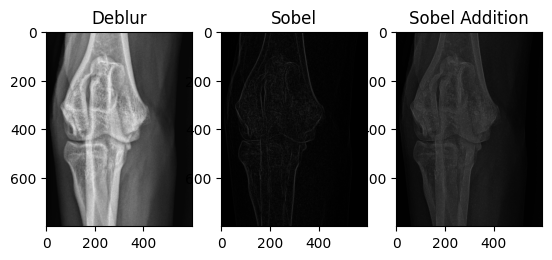

In [291]:
# Sobel Filtering
sobelImage = 5 * skimage.filters.sobel(deblurImage)
sobelResult = np.add(deblurImage,sobelImage)
subplot(131); imshow(deblurImage,cmap=cm.gray); title('Deblur');
subplot(132); imshow(sobelImage,cmap=cm.gray); title('Sobel');
subplot(133); imshow(sobelResult,cmap=cm.gray); title('Sobel Addition');
# PSNR
psnrSobel = findPSNR(sobelResult, deblurImage)
print('PSNR of Sobel =', psnrSobel)

PSNR of Histogram Equalization = 14.991119201889273


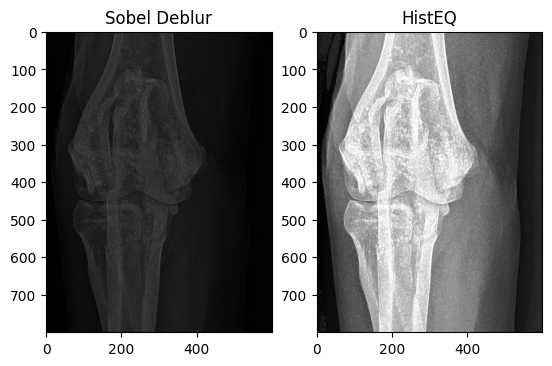

In [292]:
histImage = compInt * skimage.exposure.equalize_hist(sobelResult,2**12)
subplot(121); imshow(sobelResult,cmap=cm.gray); title('Sobel Deblur');
subplot(122); imshow(histImage,cmap=cm.gray); title('HistEQ');
# PSNR
psnrHisteq = findPSNR(histImage, sobelResult)
print('PSNR of Histogram Equalization =', psnrHisteq)

PSNR of Filtered Output = 15.359858944884381


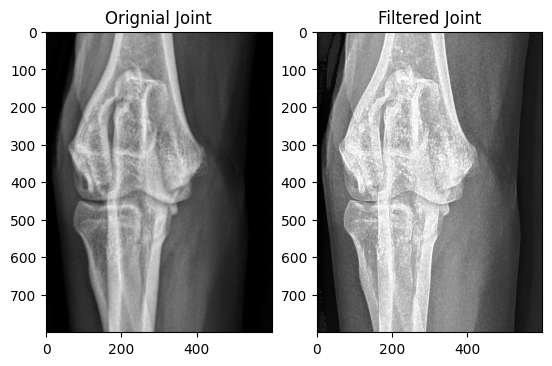

In [293]:
# display orignial segment and filtered
subplot(121); imshow(onlyJoint, cmap = cm.gray); title('Orignial Joint')
subplot(122); imshow(histImage, cmap = cm.gray); title('Filtered Joint')
# PSNR
psnrFilteredOutput = findPSNR(histImage, onlyJoint)
print('PSNR of Filtered Output =', psnrFilteredOutput)

In [294]:
# Median #extra, doesnt really affect the final output
#medImage = skimage.filters.median(histImage)
#subplot(121); imshow(histImage,cmap=cm.gray); title('Hist EQ');
#subplot(122); imshow(medImage,cmap=cm.gray); title('Median Filter');